In [ ]:
!python3 -m pip install open_spiel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94505 sha256=d36c39fc2ebf88b5201ad3672f767fc2d2040d2e6bf8566a805cc686683f1a5e
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml-collections


In [ ]:
from absl import logging
import numpy as np
import tensorflow.compat.v1 as tf

from open_spiel.python import rl_environment
from open_spiel.python.algorithms import dqn
from open_spiel.python.algorithms import random_agent

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import drive
import datetime
import pytz
import os
# Training parameters

#Directory to save/load the agent models.
time = datetime.datetime.utcnow().astimezone(pytz.timezone('US/Eastern')).strftime("%Y-%m-%d_%H:%M:%S")
drive.mount('/content/drive', force_remount=True)
checkpoint_dir = "/content/drive/My Drive/TrainedAgents/Checkers/" + time
os.makedirs(checkpoint_dir)
#Episode frequency at which the DQN agent models are saved
save_every = int(1e4)

#Number of training episodes.
num_train_episodes = int(1e6)

#Episode frequency at which the DQN agents are evaluated.
eval_every = 1000


# DQN model hyper-parameters

#Number of hidden units in the Q-Network MLP
hidden_layers_sizes = [64, 64]

#Size of the replay buffer
replay_buffer_capacity = int(1e5)

#Number of transitions to sample at each learning step.                     )
batch_size = 32

Mounted at /content/drive


In [ ]:
def eval_against_random_bots(env, trained_agents, random_agents, num_episodes):
  """Evaluates `trained_agents` against `random_agents` for `num_episodes`."""
  num_players = len(trained_agents)
  sum_episode_rewards = np.zeros(num_players)
  for player_pos in range(num_players):
    cur_agents = random_agents[:]
    cur_agents[player_pos] = trained_agents[player_pos]
    for _ in range(num_episodes):
      time_step = env.reset()
      episode_rewards = 0
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if env.is_turn_based:
          agent_output = cur_agents[player_id].step(
              time_step, is_evaluation=True)
          action_list = [agent_output.action]
        else:
          agents_output = [
              agent.step(time_step, is_evaluation=True) for agent in cur_agents
          ]
          action_list = [agent_output.action for agent_output in agents_output]
        time_step = env.step(action_list)
        episode_rewards += time_step.rewards[player_pos]
      sum_episode_rewards[player_pos] += episode_rewards
  return sum_episode_rewards / num_episodes

In [ ]:
game = "connect_four"
num_players = 2
env = rl_environment.Environment(game)
info_state_size = env.observation_spec()["info_state"][0]
num_actions = env.action_spec()["num_actions"]

# random agents for evaluation
random_agents = [
    random_agent.RandomAgent(player_id=idx, num_actions=num_actions)
    for idx in range(num_players)
]

with tf.Session() as sess:
  hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
  # pylint: disable=g-complex-comprehension
  agents = [
      dqn.DQN(
          session=sess,
          player_id=idx,
          state_representation_size=info_state_size,
          num_actions=num_actions,
          hidden_layers_sizes=hidden_layers_sizes,
          replay_buffer_capacity=replay_buffer_capacity,
          batch_size=batch_size) for idx in range(num_players)
  ]
  sess.run(tf.global_variables_initializer())

  result = []
  print("Start Training...")
  for ep in range(num_train_episodes):
    if (ep + 1) % 100 == 0:
        print(ep+1)
    if (ep + 1) % eval_every == 0:
      r_mean = eval_against_random_bots(env, agents, random_agents, 1000)
      logging.info("[%s] Mean episode rewards %s", ep + 1, r_mean)
      print("Mean episode rewards %s", ep + 1, r_mean)
      result.append(r_mean)
    if (ep + 1) % save_every == 0:
      for agent in agents:
        agent.save(checkpoint_dir)

    time_step = env.reset()
    while not time_step.last():
      player_id = time_step.observations["current_player"]
      if env.is_turn_based:
        agent_output = agents[player_id].step(time_step)
        action_list = [agent_output.action]
      else:
        agents_output = [agent.step(time_step) for agent in agents]
        action_list = [agent_output.action for agent_output in agents_output]
      time_step = env.step(action_list)

    # Episode is over, step all agents with final info state.
    for agent in agents:
      agent.step(time_step)

Start Training...
100
200
300
400
500
600
700
800
900
1000
Mean episode rewards %s 1000 [0.434 0.246]
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Mean episode rewards %s 2000 [0.668 0.418]
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
Mean episode rewards %s 3000 [0.728 0.394]
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
Mean episode rewards %s 4000 [0.672 0.457]
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
Mean episode rewards %s 5000 [0.74  0.492]
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
Mean episode rewards %s 6000 [0.744 0.53 ]
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
Mean episode rewards %s 7000 [0.606 0.506]
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
Mean episode rewards %s 8000 [0.66 0.55]
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
Mean episode rewards %s 9000 [0.738 0.566]
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
Mean episode rewards %s 10000 [0.76  0.661]
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
M

KeyboardInterrupt: ignored

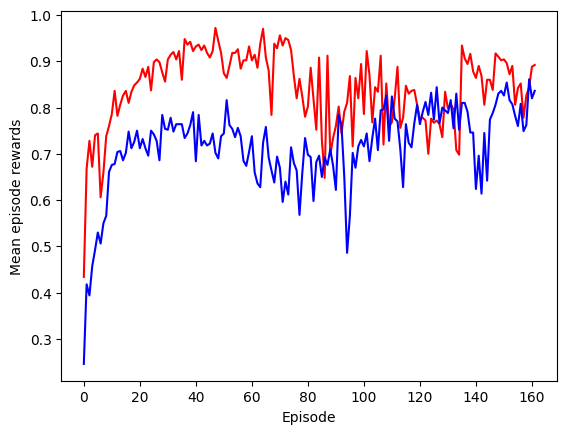

In [ ]:
import matplotlib.pyplot as plt

ep = [x for x in range(len(result))]
pt_r_mean0 = [y[0] for y in result]
pt_r_mean1 = [y[1] for y in result]

plt.plot(ep,pt_r_mean0, c='red')
plt.plot(ep,pt_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

In [ ]:
game = "connect_four"
num_players = 2
env = rl_environment.Environment(game)
print(env.game)
print(env.get_state)
info_state_size = env.observation_spec()["info_state"][0]
num_actions = env.action_spec()["num_actions"]

# random agents for evaluation
#minimax_agents = [
#    minimax_agent.MiniMaxAgent(env.game, env.get_state, player_id=idx, num_actions=num_actions, maximum_depth=8, value_function=evaluate)
#    for idx in range(num_players)
#]

with tf.Session() as sess:
    agents = [
          dqn.DQN(
              session=sess,
              player_id=idx,
              state_representation_size=info_state_size,
              num_actions=num_actions,
              hidden_layers_sizes=hidden_layers_sizes,
              replay_buffer_capacity=replay_buffer_capacity,
              batch_size=batch_size) for idx in range(num_players)
      ]
    print(type(agents[0]))
    agents[0].restore(checkpoint_dir)

connect_four()
None
<class 'open_spiel.python.algorithms.dqn.DQN'>


NotFoundError: ignored